## Make Diagnostic Plots of Data in DART-CAM6 Zarr Stores

In [1]:
import xarray as xr
import numpy as np
import dask
import intake

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
import os

from dask_jobqueue import PBSCluster

## Create and Connect to a Dask Distributed Cluster

Run the cell below if the notebook is running on a supercomputer with a PBS Scheduler.
If the notebook is running on a different parallel computing environment, you will need 
to replace the usage of `PBSCluster` with a similar object from `dask_jobqueue` or `dask_gateway`.

In [2]:
num_jobs = 20
walltime = '0:20:00'
memory='10GB' 

cluster = PBSCluster(cores=1, processes=1, walltime=walltime, memory=memory, queue='casper', 
                     resource_spec='select=1:ncpus=1:mem=10GB',)
cluster.scale(jobs=num_jobs)


from distributed import Client
client = Client(cluster)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/bonnland/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:39849,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/bonnland/proxy/8787/status,Total threads: 0
Started: 5 minutes ago,Total memory: 0 B


☝️ Link to Dask dashboard will appear above.

## Find and Obtain Data Using an Intake Catalog

#### Choose Cloud Storage (AWS or NCAR Cloud)

In [3]:
# If True,  use NCAR Cloud Storage.   Requires an NCAR user account.
# If False, use AWS  Cloud Storage.

USE_NCAR_CLOUD_STORAGE = False

#### Define the Intake Catalog URL and Storage Access Options

In [4]:
if USE_NCAR_CLOUD_STORAGE:
    catalog_url = "https://stratus.ucar.edu/ncar-dart-cam6/catalogs/aws-dart-cam6.json"
    storage_options={"anon": True, 'client_kwargs':{"endpoint_url":"https://stratus.ucar.edu/"}}
                     
else:
    catalog_url = "https://ncar-dart-cam6.s3-us-west-2.amazonaws.com/catalogs/aws-dart-cam6.json"
    storage_options={"anon": True}

#### Open catalog and produce a content summary

In [5]:
# Define the catalog description file location

# Open the catalog
col = intake.open_esm_datastore(catalog_url)
col

,unique
variable,11
long_name,11
units,6
standard_name,10
vertical_levels,2
component,2
spatial_domain,1
start_time,2
end_time,2
frequency,2


In [6]:
# Produce a catalog content summary.

uniques = col.unique()

print(f'variables: {uniques["variable"]}\n')

variables: ['HR', 'TSA', 'EFLX_LH_TOT', 'ER', 'VS', 'PS', 'Q', 'US', 'CLDICE', 'T', 'CLDLIQ']



#### Load data into xarray using the catalog

In [7]:
data_var = 'PS'

col_subset = col.search(variable=data_var)
col_subset

,unique
variable,1
long_name,1
units,1
standard_name,1
vertical_levels,1
component,1
spatial_domain,1
start_time,1
end_time,1
frequency,1


#### Show the chosen Zarr store attributes

In [8]:
col_subset.df

,variable,long_name,units,standard_name,vertical_levels,component,spatial_domain,start_time,end_time,frequency,path
0,PS,Surface pressure,Pa,surface_air_pressure,1,atm,global,2011-01-03T00:00:00,2019-12-30T00:00:00,weekly,s3://ncar-dart-cam6/weekly/PS.zarr


#### Convert catalog subset to a dictionary of xarray datasets, and use the first one.

In [9]:
dsets = col_subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True}, storage_options=storage_options
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")

# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
ds = dsets[dataset_key]

ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.component.vertical_levels'



Dataset dictionary keys:
 dict_keys(['PS.weekly.atm.1'])


<xarray.Dataset>
Dimensions:    (member_id: 80, time: 471, lat: 192, lon: 288, ilev: 33,
                lev: 32, slat: 191, slon: 288)
Coordinates:
  * ilev       (ilev) float32 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat        (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float32 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon        (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 ... 73 74 75 76 77 78 79 80
  * slat       (slat) float32 -89.53 -88.59 -87.64 -86.7 ... 87.64 88.59 89.53
  * slon       (slon) float32 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
  * time       (time) datetime64[ns] 2011-01-03 2011-01-10 ... 2019-12-30
Data variables:
    PS         (member_id, time, lat, lon) float64 dask.array<chunksize=(80, 80, 32, 32), meta=np.ndarray>
Attributes: (12/28)
    DART_creation_date:                YYYY MM DD HH MM SS = 2019 07 10 01 31 17
    DART_revdate:                      $Date: 2019-03-26 09:18:06 -0600 (Tue,...
    DART_revision:                     $Revision: 13074 $
    DART_source:                       $URL: https://svn-dares-dart.cgd.ucar....
    creation_date:                     YYYY MM DD HH MM SS = 2019 07 10 01 31 17
    dataset-zarr-version:              1.0
    ...                                ...
    intake_esm_attrs:start_time:       2011-01-03T00:00:00
    intake_esm_attrs:end_time:         2019-12-30T00:00:00
    intake_esm_attrs:frequency:        weekly
    intake_esm_attrs:path:             s3://ncar-dart-cam6/weekly/PS.zarr
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            PS.weekly.atm.1

## Define Plot Functions

#### Get consistently shaped data slices for both 2D and 3D variables.

In [10]:
def getSlice(ds, data_var):
    '''If the data has vertical levels, choose the level closest
       to the Earth's surface for 2-D diagnostic plots.
    '''
    data_slice = ds[data_var]

    if 'lev' in data_slice.dims:
        lastLevel = ds.lev.values[-1]
        data_slice = data_slice.sel(lev = lastLevel)
        data_slice = data_slice.squeeze()

    return data_slice

#### Get lat/lon dimension names 

In [11]:
def getSpatialDimensionNames(data_slice):
    '''Get the spatial dimension names for this data slice.
    '''
    # Determine lat/lon conventions for this slice.
    lat_dim = 'lat' if 'lat' in data_slice.dims else 'slat'
    lon_dim = 'lon' if 'lon' in data_slice.dims else 'slon'
    
    return [lat_dim, lon_dim]

#### Produce Time Series Spaghetti Plot of Ensemble Members

In [12]:
def plot_timeseries(ds, data_var, store_name):
    '''Create a spaghetti plot for a given variable.
    '''
    figWidth = 25 
    figHeight = 20
    linewidth = 0.5

    numPlotsPerPage = 3
    numPlotCols = 1
    
    # Plot the aggregate statistics across time.
    fig, axs = plt.subplots(3, 1, figsize=(figWidth, figHeight))

    data_slice = getSlice(ds, data_var)
    spatial_dims = getSpatialDimensionNames(data_slice)

    unit_string = ds[data_var].attrs['units']

    # Persist the slice so it's read from disk only once.
    # This is faster when data values are reused many times.
    data_slice = data_slice.persist()

    max_vals = data_slice.max(dim = spatial_dims).transpose()
    mean_vals = data_slice.mean(dim = spatial_dims).transpose()
    min_vals = data_slice.min(dim = spatial_dims).transpose()

    
    rangeMaxs = max_vals.max(dim = 'member_id')
    rangeMins = max_vals.min(dim = 'member_id')
    axs[0].set_facecolor('lightgrey')
    axs[0].fill_between(ds.time, rangeMins, rangeMaxs, linewidth=linewidth, color='white')
    axs[0].plot(ds.time, max_vals, linewidth=linewidth, color='red', alpha=0.1)
    axs[0].set_title('Ensemble Member Maxima Over Time', fontsize=20)
    axs[0].set_ylabel(unit_string)

    rangeMaxs = mean_vals.max(dim = 'member_id')
    rangeMins = mean_vals.min(dim = 'member_id')
    axs[1].set_facecolor('lightgrey')
    axs[1].fill_between(ds.time, rangeMins, rangeMaxs, linewidth=linewidth, color='white')
    axs[1].plot(ds.time, mean_vals, linewidth=linewidth, color='red', alpha=0.1)
    axs[1].set_title('Ensemble Member Means Over Time', fontsize=20)
    axs[1].set_ylabel(unit_string)

    rangeMaxs = min_vals.max(dim = 'member_id')
    rangeMins = min_vals.min(dim = 'member_id')
    axs[2].set_facecolor('lightgrey')
    axs[2].fill_between(ds.time, rangeMins, rangeMaxs, linewidth=linewidth, color='white')
    axs[2].plot(ds.time, min_vals, linewidth=linewidth, color='red', alpha=0.1)
    axs[2].set_title('Ensemble Member Minima Over Time', fontsize=20)
    axs[2].set_ylabel(unit_string)

    plt.suptitle(store_name, fontsize=25)
    
    return fig

### Actually Create Spaghetti Plot Showing All Ensemble Members

CPU times: user 6.9 s, sys: 408 ms, total: 7.3 s
Wall time: 31.2 s


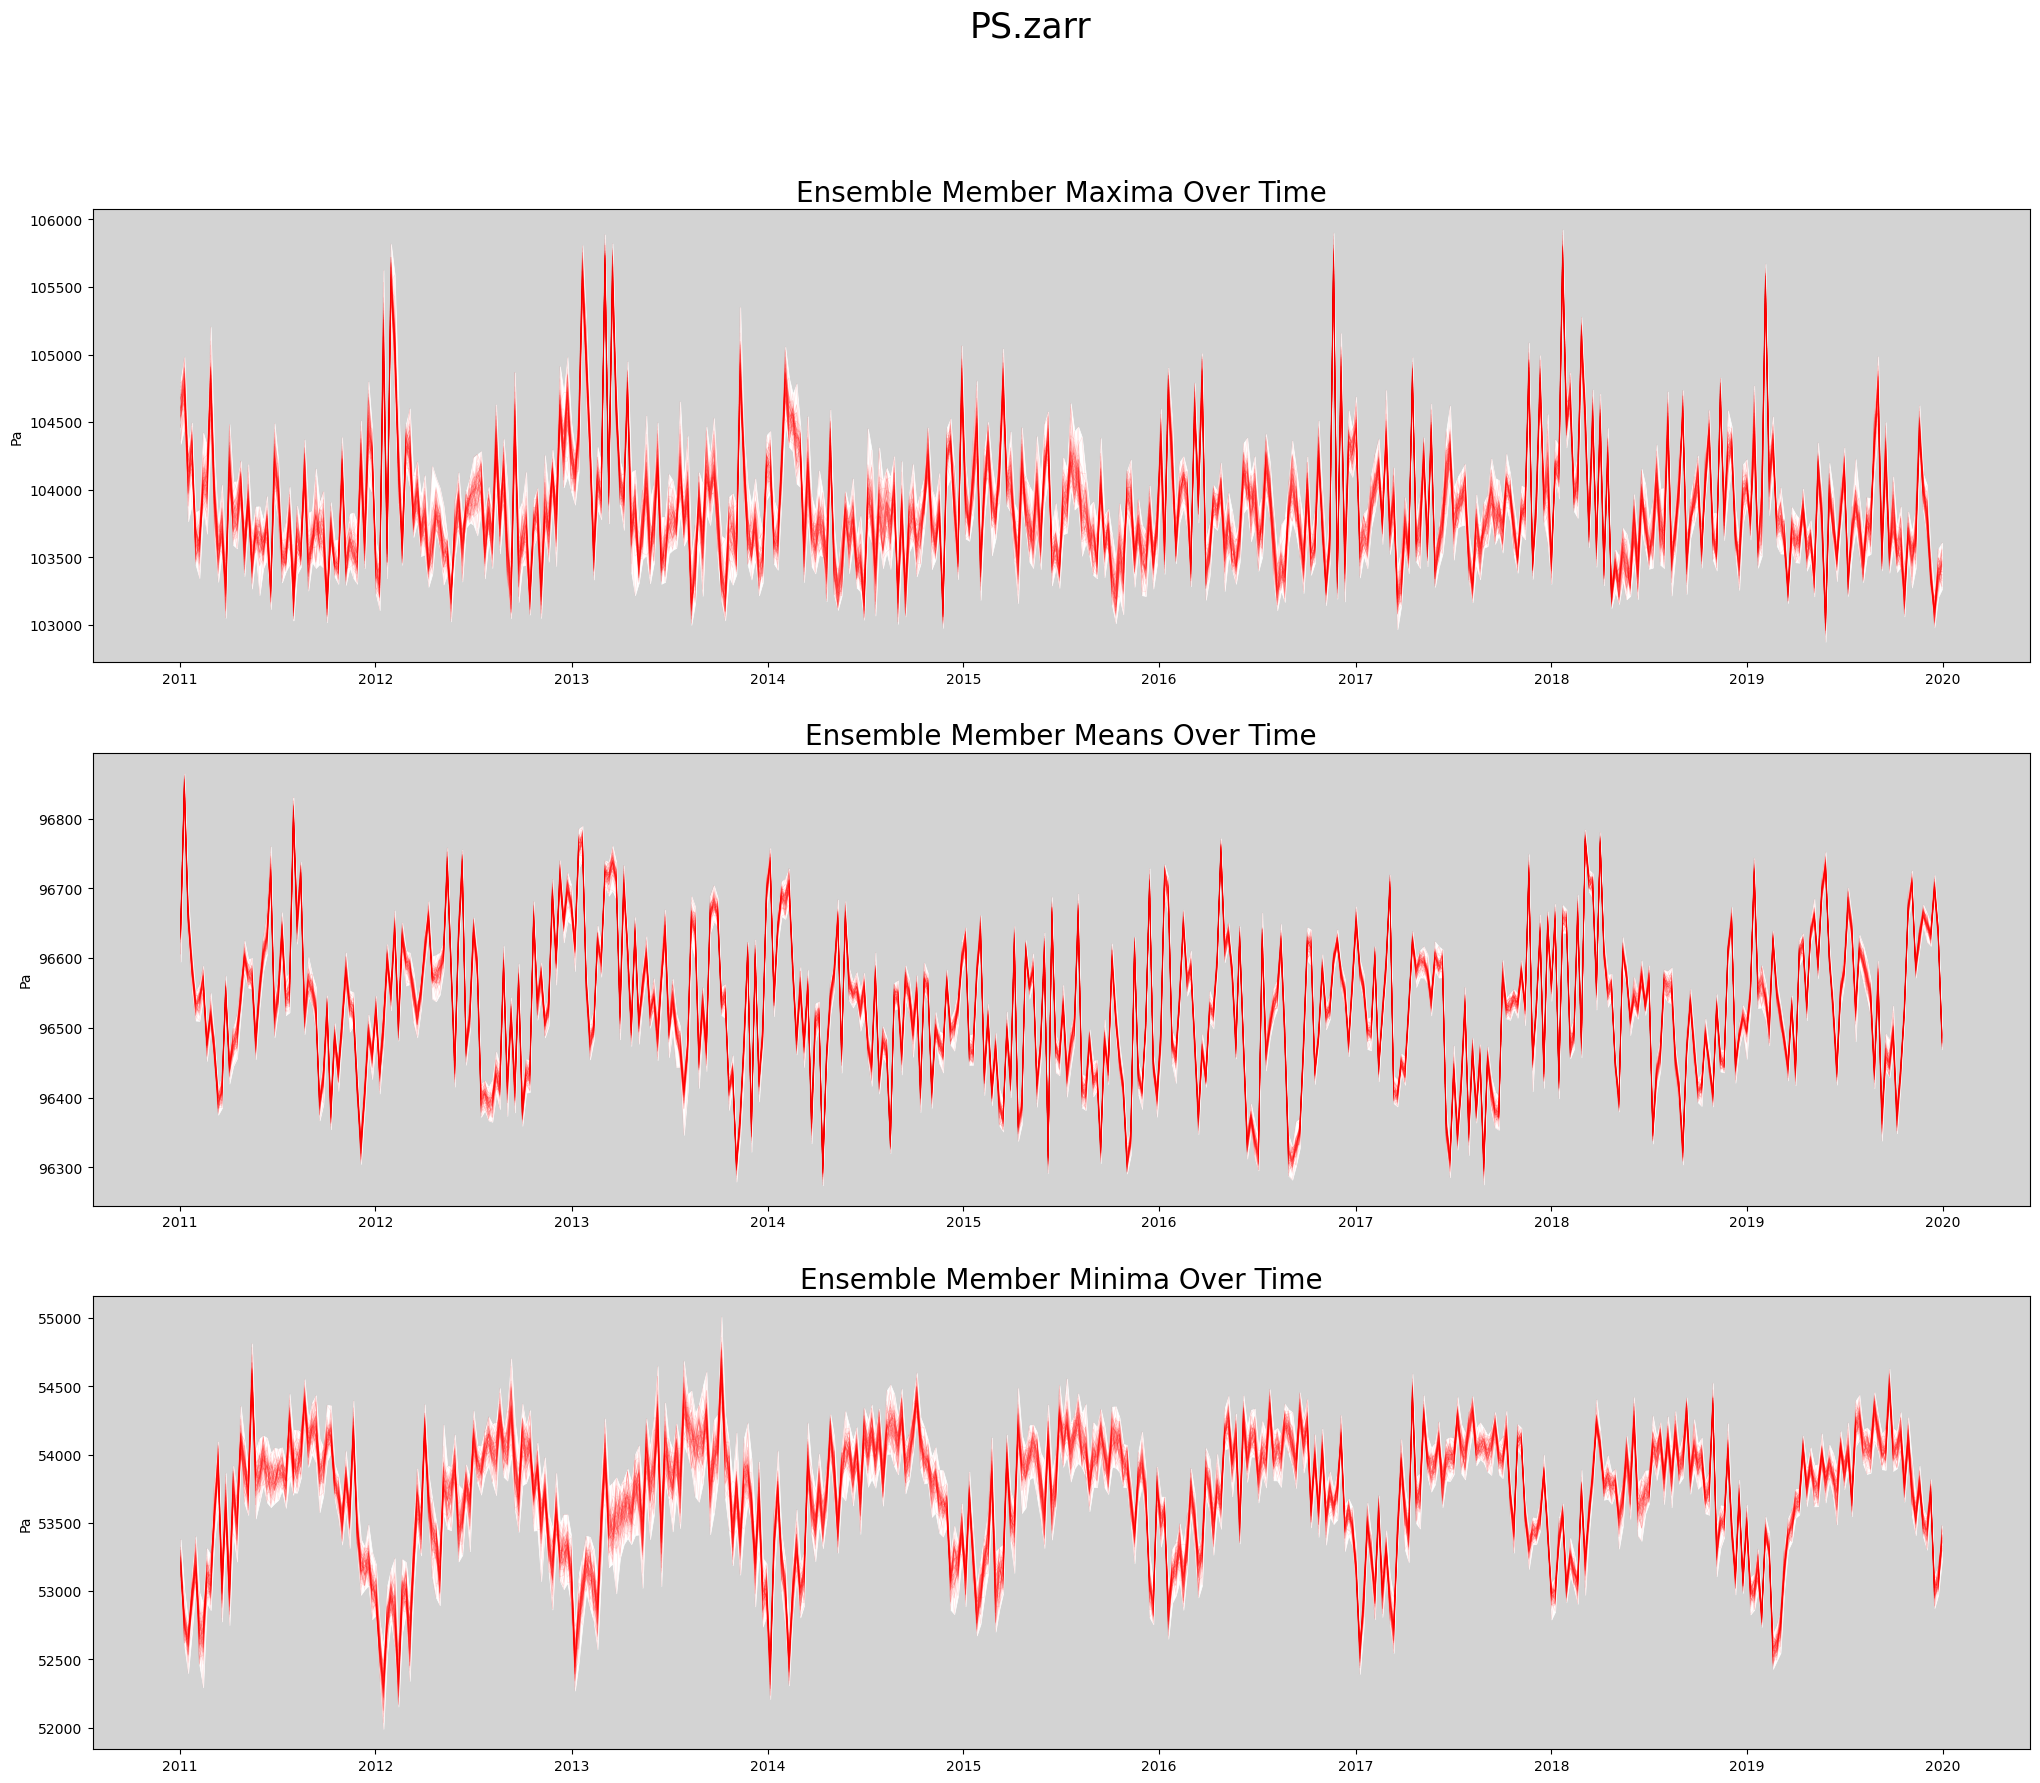

In [13]:
%%time

store_name = f'{data_var}.zarr'
fig = plot_timeseries(ds, data_var, store_name)

### Save/Download the figure

To download the figure plot file:
* Run the following command.
* Find the file using the Jupyter file browser in the left sidebar.
* Right-click the file name, and select "Download".

In [14]:
fig.savefig(f'{data_var}.zarr.pdf', facecolor='white', dpi=200)

### Release the Dask workers.

In [15]:
!date

Thu May 11 14:58:06 MDT 2023


In [16]:
cluster.close()

### Show which python package versions were used

In [17]:
%load_ext watermark
%watermark -iv

matplotlib: 3.7.1
intake    : 0.6.8
sys       : 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:57:19) [GCC 11.3.0]
xarray    : 2023.4.2
json      : 2.0.9
dask      : 2023.4.1
numpy     : 1.24.3

